## Purpose

* Get the pre-trained ResNet18 model and train it for CIFAR10 dataset
* Find 50 misclassified images from validation set
* For those misclassified images, check which features the model (considering a particular layer) was looking at by using GradCAM

## Get pre-trained ResNet18 (Available only for ImageNet dataset)

In [1]:
!pip install image-classifiers

     |████████████████████████████████| 81kB 3.2MB/s 


In [2]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-w03m5pzh
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-w03m5pzh
  Running command git submodule update --init --recursive -q
  Stored in directory: /tmp/pip-ephem-wheel-cache-70c2vi_g/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [3]:
from classification_models.resnet import ResNet18, preprocess_input

Using TensorFlow backend.


Since CIFAR10 image size is 32x32, specify the same input dimension while loading the ResNet model weights 

In [4]:
model = ResNet18((32, 32, 3), weights='imagenet')

W0718 05:37:04.259866 139808395523968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 05:37:04.326175 139808395523968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 05:37:04.327388 139808395523968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0718 05:37:04.332082 139808395523968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0718 05:37:04.334728 139808

46981120/46977688 [==============================] - 0s 0us/step


In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
from keras.models import Sequential, Model
from keras.layers import Conv2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers.advanced_activations import ReLU

In [6]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 3s 0us/step


Loading the model without the last layer.

In [7]:
base_model = ResNet18(input_shape=(32,32,3), weights='imagenet', include_top=False)

A local file was found, but it seems to be incomplete or outdated because the md5 file hash does not match the original value of 318e3ac0cd98d51e917526c9f62f0b50 so we will re-download the data.
44924928/44920640 [==============================] - 1s 0us/step


Print the name of each layer of the model

In [8]:
for i,layer in enumerate(base_model.layers):
  print(i,layer.name)

0 data
1 bn_data
2 zero_padding2d_19
3 conv0
4 bn0
5 relu0
6 zero_padding2d_20
7 pooling0
8 stage1_unit1_bn1
9 stage1_unit1_relu1
10 zero_padding2d_21
11 stage1_unit1_conv1
12 stage1_unit1_bn2
13 stage1_unit1_relu2
14 zero_padding2d_22
15 stage1_unit1_conv2
16 stage1_unit1_sc
17 add_9
18 stage1_unit2_bn1
19 stage1_unit2_relu1
20 zero_padding2d_23
21 stage1_unit2_conv1
22 stage1_unit2_bn2
23 stage1_unit2_relu2
24 zero_padding2d_24
25 stage1_unit2_conv2
26 add_10
27 stage2_unit1_bn1
28 stage2_unit1_relu1
29 zero_padding2d_25
30 stage2_unit1_conv1
31 stage2_unit1_bn2
32 stage2_unit1_relu2
33 zero_padding2d_26
34 stage2_unit1_conv2
35 stage2_unit1_sc
36 add_11
37 stage2_unit2_bn1
38 stage2_unit2_relu1
39 zero_padding2d_27
40 stage2_unit2_conv1
41 stage2_unit2_bn2
42 stage2_unit2_relu2
43 zero_padding2d_28
44 stage2_unit2_conv2
45 add_12
46 stage3_unit1_bn1
47 stage3_unit1_relu1
48 zero_padding2d_29
49 stage3_unit1_conv1
50 stage3_unit1_bn2
51 stage3_unit1_relu2
52 zero_padding2d_30
53 stag

In [9]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

## Update the pre-trained model architecture for CIFAR10

Since ResNet18 is trained on ImageNet dataset and we are using it for CIFAR10 dataset, we need to change the last few layers of the architecture so as to make it work for training on different number of classes. Moreover, the original model is using Dense layer and we intend to get rid of it. Hence, replacing last few convolution layers with our convolution layers followed by 1x1 conv to reduce the number of channels and GlobalAveragePooling to take the average of each feature map.

In [0]:
x = base_model.get_layer('zero_padding2d_29').output
x = Conv2D(256, kernel_size = (3, 3), strides=(1,1), padding='same', name='conv_added_1_3x3', dilation_rate=(1, 1), use_bias=False)(x)
x = BatchNormalization(name='norm_added_1')(x)
x = ReLU()(x)

x = Conv2D(256, kernel_size = (3, 3), strides=(1,1), padding='same', name='conv_added_2_3x3', dilation_rate=(1, 1), use_bias=False)(x)
x = BatchNormalization(name='norm_added_2')(x)
x = ReLU()(x)

x = Conv2D(10, kernel_size = (1, 1), name='conv_added_3_1x1', use_bias=False)(x)

x = GlobalAveragePooling2D()(x)

output = Activation('softmax')(x)

model = Model(inputs=[base_model.input], outputs=[output])

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

In [12]:
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 data
1 bn_data
2 zero_padding2d_19
3 conv0
4 bn0
5 relu0
6 zero_padding2d_20
7 pooling0
8 stage1_unit1_bn1
9 stage1_unit1_relu1
10 zero_padding2d_21
11 stage1_unit1_conv1
12 stage1_unit1_bn2
13 stage1_unit1_relu2
14 zero_padding2d_22
15 stage1_unit1_conv2
16 stage1_unit1_sc
17 add_9
18 stage1_unit2_bn1
19 stage1_unit2_relu1
20 zero_padding2d_23
21 stage1_unit2_conv1
22 stage1_unit2_bn2
23 stage1_unit2_relu2
24 zero_padding2d_24
25 stage1_unit2_conv2
26 add_10
27 stage2_unit1_bn1
28 stage2_unit1_relu1
29 zero_padding2d_25
30 stage2_unit1_conv1
31 stage2_unit1_bn2
32 stage2_unit1_relu2
33 zero_padding2d_26
34 stage2_unit1_conv2
35 stage2_unit1_sc
36 add_11
37 stage2_unit2_bn1
38 stage2_unit2_relu1
39 zero_padding2d_27
40 stage2_unit2_conv1
41 stage2_unit2_bn2
42 stage2_unit2_relu2
43 zero_padding2d_28
44 stage2_unit2_conv2
45 add_12
46 stage3_unit1_bn1
47 stage3_unit1_relu1
48 zero_padding2d_29
49 conv_added_1_3x3
50 norm_added_1
51 re_lu_1
52 conv_added_2_3x3
53 norm_added_2
54 re_lu_

## Train the updated model

Training only the newly added layers for CIFAR10

In [0]:
for layer in model.layers[:49]:
    layer.trainable=False
for layer in model.layers[49:]:
    layer.trainable=True

In [0]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)


In [15]:
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

W0718 05:39:17.839122 139808395523968 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
train_labels_orig = train_labels.copy()
test_labels_orig = test_labels.copy()
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

Using preprocess_input so as to transform the input image in a way in accordance with the required format for the pre-trained model ResNet18.

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [18]:
model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 20, 
                                 validation_data = (test_features, test_labels), verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=20)`
  This is separate from the ipykernel package so we can avoid doing imports until
W0718 05:39:27.700890 139808395523968 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math

Epoch 1/20
390/390 [==============================] - 334s 855ms/step - loss: 0.9892 - acc: 0.6597 - val_loss: 1.9442 - val_acc: 0.5288
Epoch 2/20
390/390 [==============================] - 334s 856ms/step - loss: 0.7229 - acc: 0.7495 - val_loss: 1.8375 - val_acc: 0.5489
Epoch 3/20
390/390 [==============================] - 333s 854ms/step - loss: 0.6285 - acc: 0.7806 - val_loss: 1.2534 - val_acc: 0.6368
Epoch 4/20
390/390 [==============================] - 333s 854ms/step - loss: 0.5528 - acc: 0.8079 - val_loss: 1.4046 - val_acc: 0.6340
Epoch 5/20
390/390 [==============================] - 333s 854ms/step - loss: 0.4900 - acc: 0.8313 - val_loss: 1.5446 - val_acc: 0.6242
Epoch 6/20
390/390 [==============================] - 334s 855ms/step - loss: 0.4359 - acc: 0.8490 - val_loss: 1.3814 - val_acc: 0.6488
Epoch 7/20
390/390 [==============================] - 334s 856ms/step - loss: 0.3861 - acc: 0.8663 - val_loss: 1.7177 - val_acc: 0.6162
Epoch 8/20
390/390 [============================

## Find 50 misclassified images

Now that the model is trained, get the prediction values for the test images.

In [0]:
test_features_X = preprocess_input(test_features)
y_pred = model.predict(test_features_X)

In [20]:
y_pred_digits=np.argmax(y_pred,axis=1)
y_pred_digits[:9]

array([7, 8, 1, 0, 4, 7, 1, 7, 7])

In [0]:
mis_class=[]

i=0
for i in range(len(test_labels_orig)):
    if(test_labels_orig[i]) != y_pred_digits[i]:
        mis_class.append(i)
    if(len(mis_class)==50):
        break

In [0]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

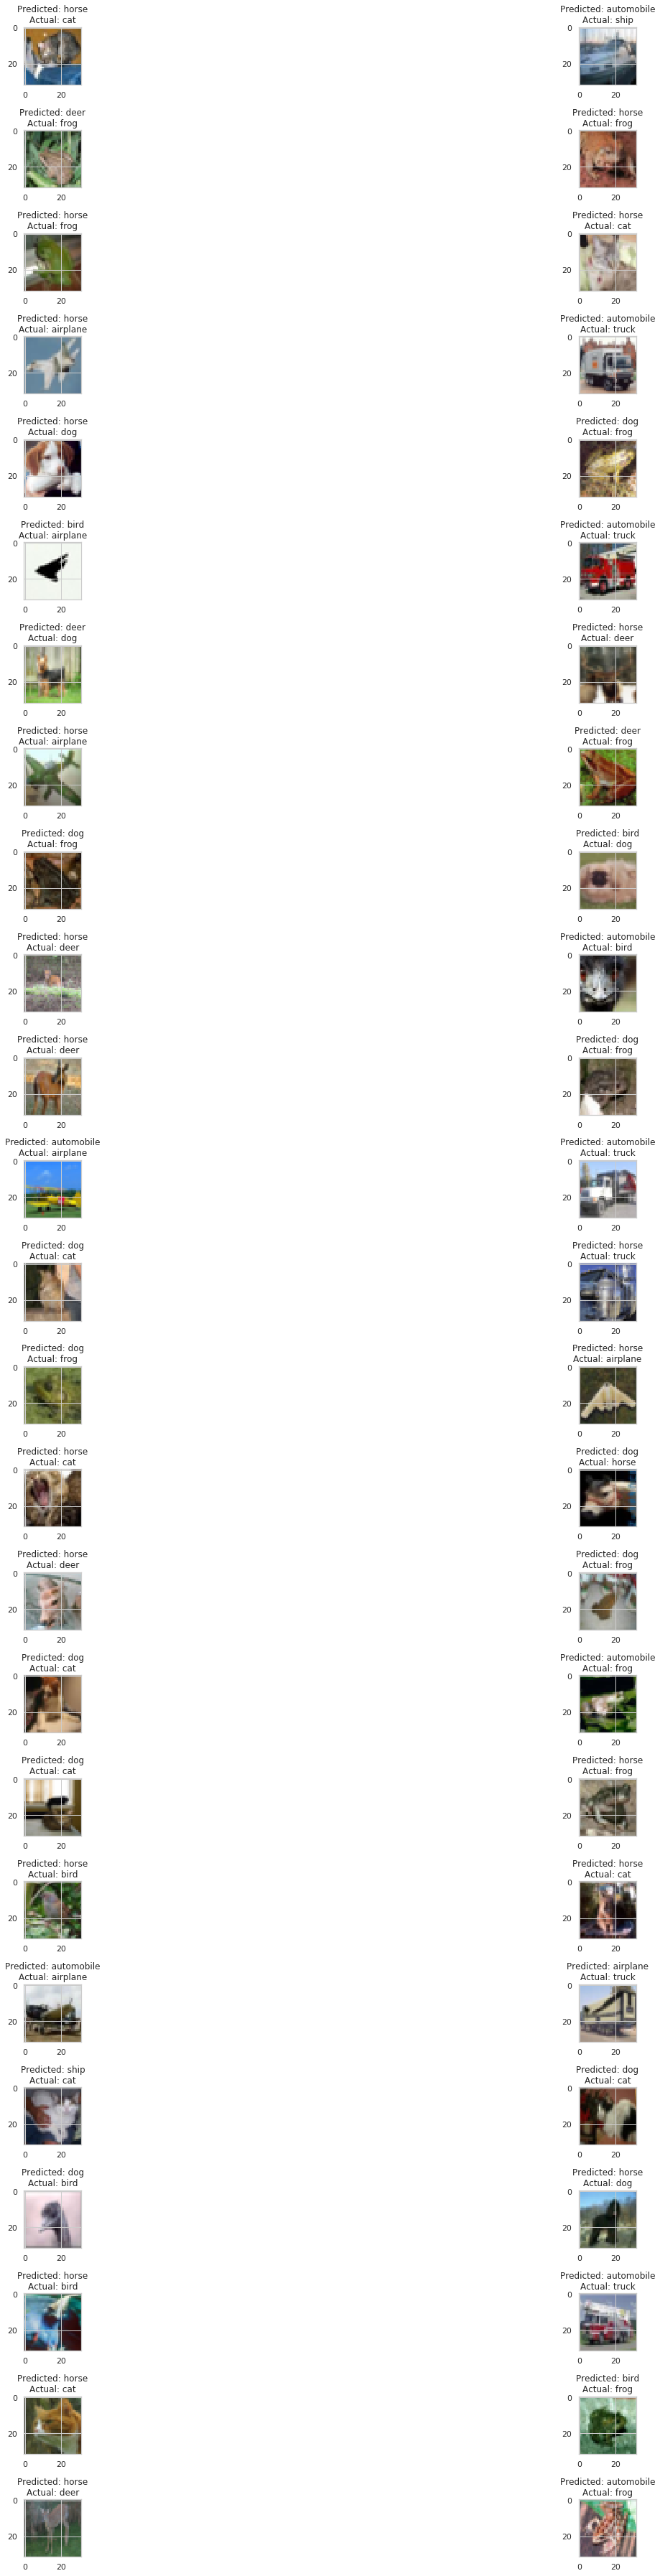

In [23]:
class_names = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

count=0
fig,ax=plt.subplots(25,2)
fig.set_size_inches(50,50)
for i in range (25):
    for j in range (2):
        ax[i,j].imshow(test_features[mis_class[count]])
        actual = class_names[(test_labels_orig[mis_class[count]])[0]]
        predicted = class_names[y_pred_digits[mis_class[count]]]
        ax[i,j].set_title("Predicted: "+ str(predicted)+ "\n" + "Actual: "+str(actual))
        plt.tight_layout()
        count+=1

## Use GradCAM

**Using GradCAM to find where on the image exactly the model was looking at so as to make the prediction.**

In [24]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

Creating a function to find GradCAM for a given image and layer.

In [0]:
import cv2

def get_grad_cam(img_idx, conv_layer, output_channel):
  x = train_features[img_idx]
  x = preprocess_input(x)
  x = np.expand_dims(x, axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(conv_layer)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(output_channel):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  img = train_features[img_idx]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  images_stack = [img, superimposed_img]
  
  return images_stack

**Visualize GradCAM heatmap for each of the 50 misclassified images and download the resulted images.**

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


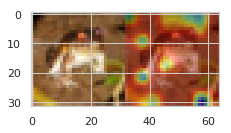

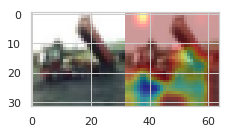

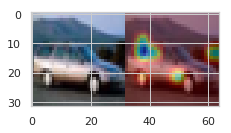

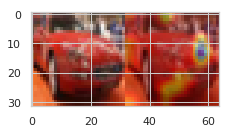

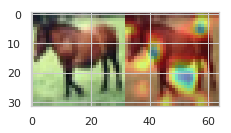

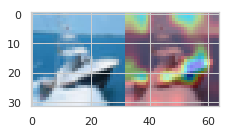

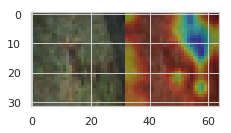

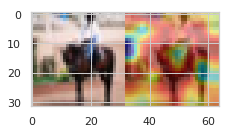

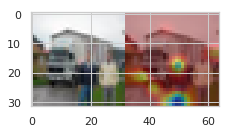

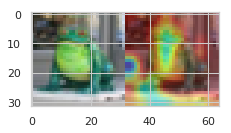

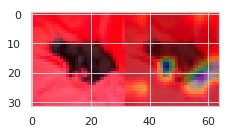

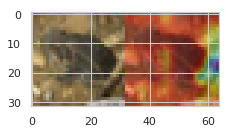

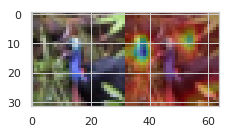

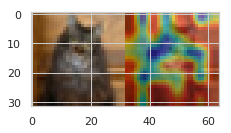

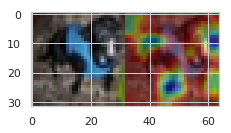

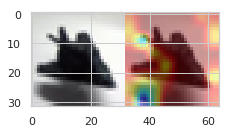

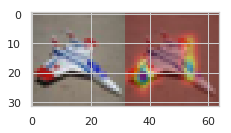

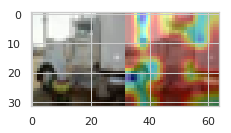

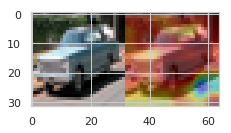

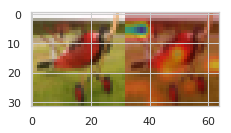

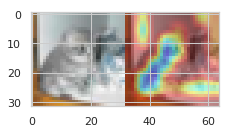

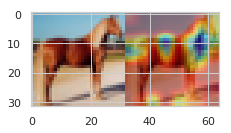

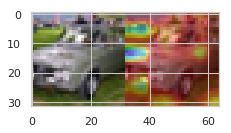

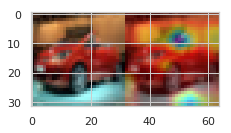

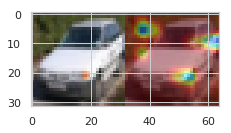

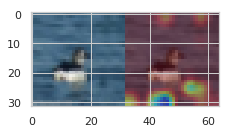

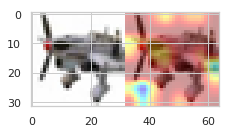

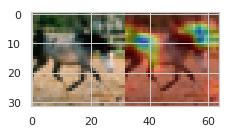

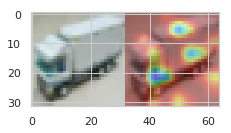

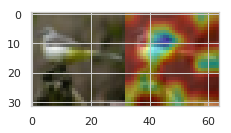

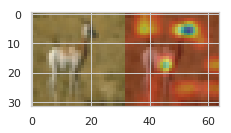

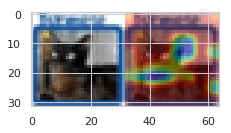

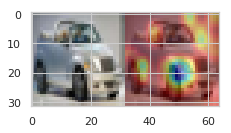

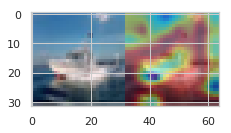

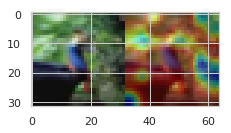

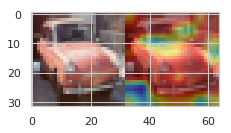

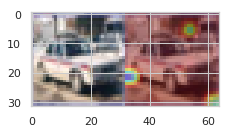

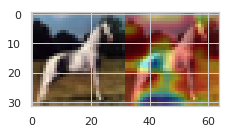

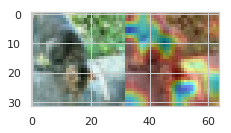

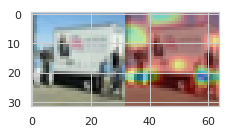

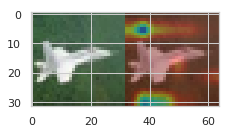

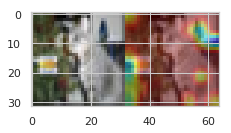

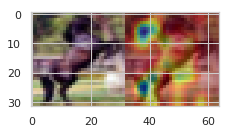

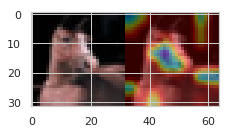

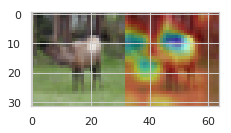

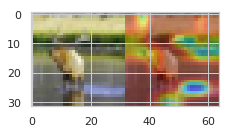

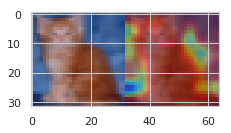

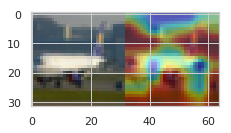

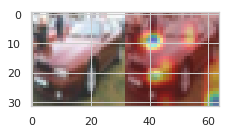

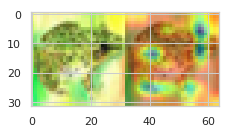

In [29]:
from google.colab import files

for i in mis_class:
  images_stack = get_grad_cam(i, "stage1_unit2_conv2", 64)
  fig = plt.figure(figsize=(3,2))
  plt.imshow(np.hstack(images_stack))
  img_name = "misc_image_w_gradcam" + str(i) + r'.png'
  plt.imsave(img_name, np.hstack(images_stack))
  files.download(img_name)

Checking the GradCAM activation for another layer

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


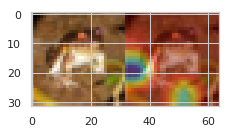

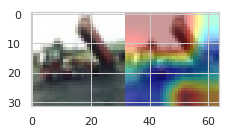

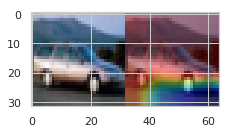

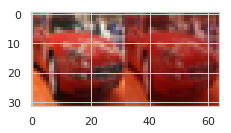

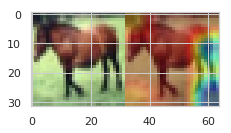

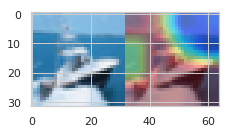

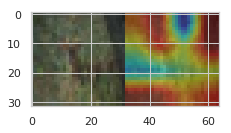

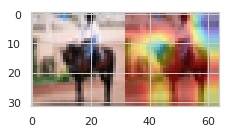

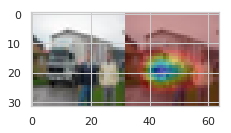

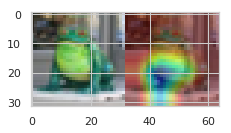

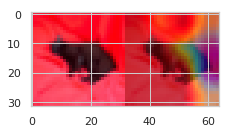

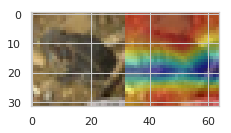

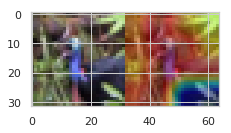

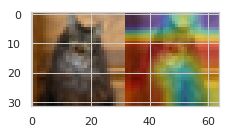

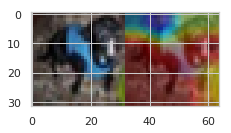

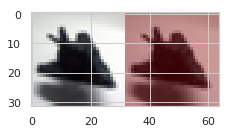

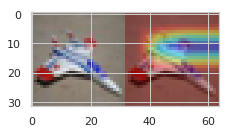

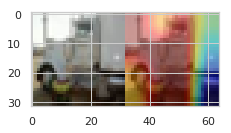

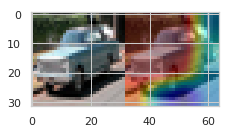

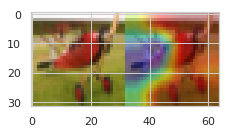

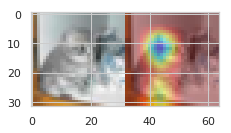

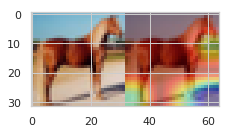

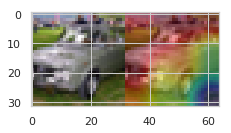

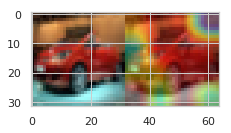

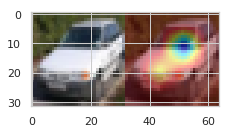

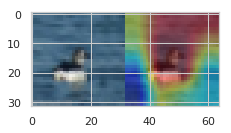

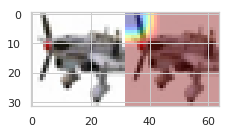

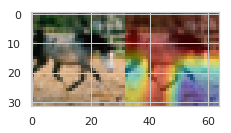

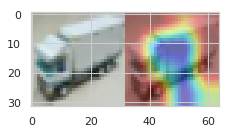

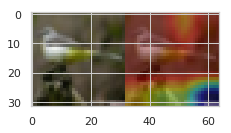

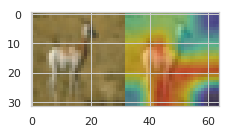

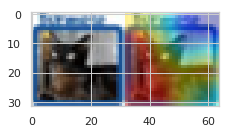

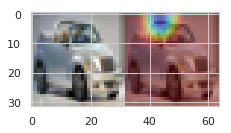

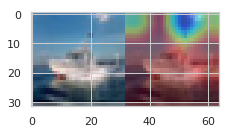

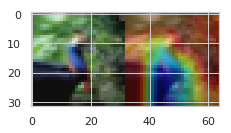

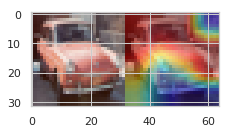

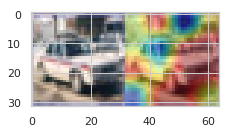

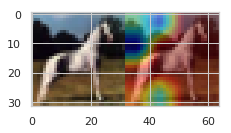

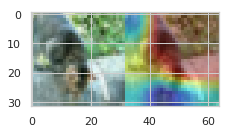

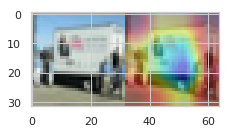

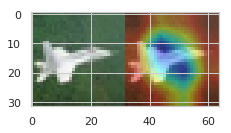

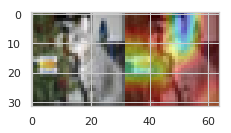

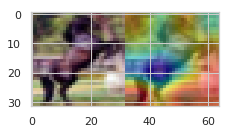

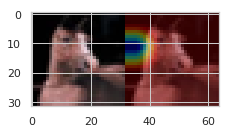

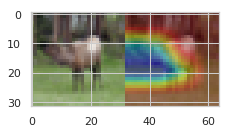

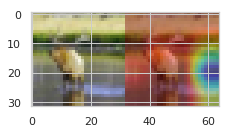

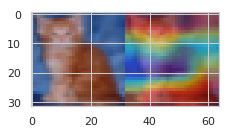

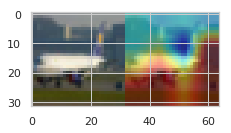

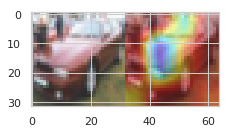

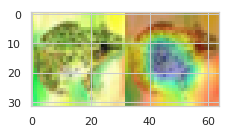

In [30]:
for i in mis_class:
  images_stack = get_grad_cam(i, "stage2_unit2_conv2", 128)
  fig = plt.figure(figsize=(3,2))
  plt.imshow(np.hstack(images_stack))
  #img_name = "misc_image_w_gradcam" + str(i) + r'.png'
  #plt.imsave(img_name, np.hstack(images_stack))
  #files.download(img_name)